# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
%matplotlib inline
import warnings 

---
## 2. Load data

In [38]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [39]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


In [40]:
df.describe().T

df.drop(columns=['net_margin', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act'], inplace=True)

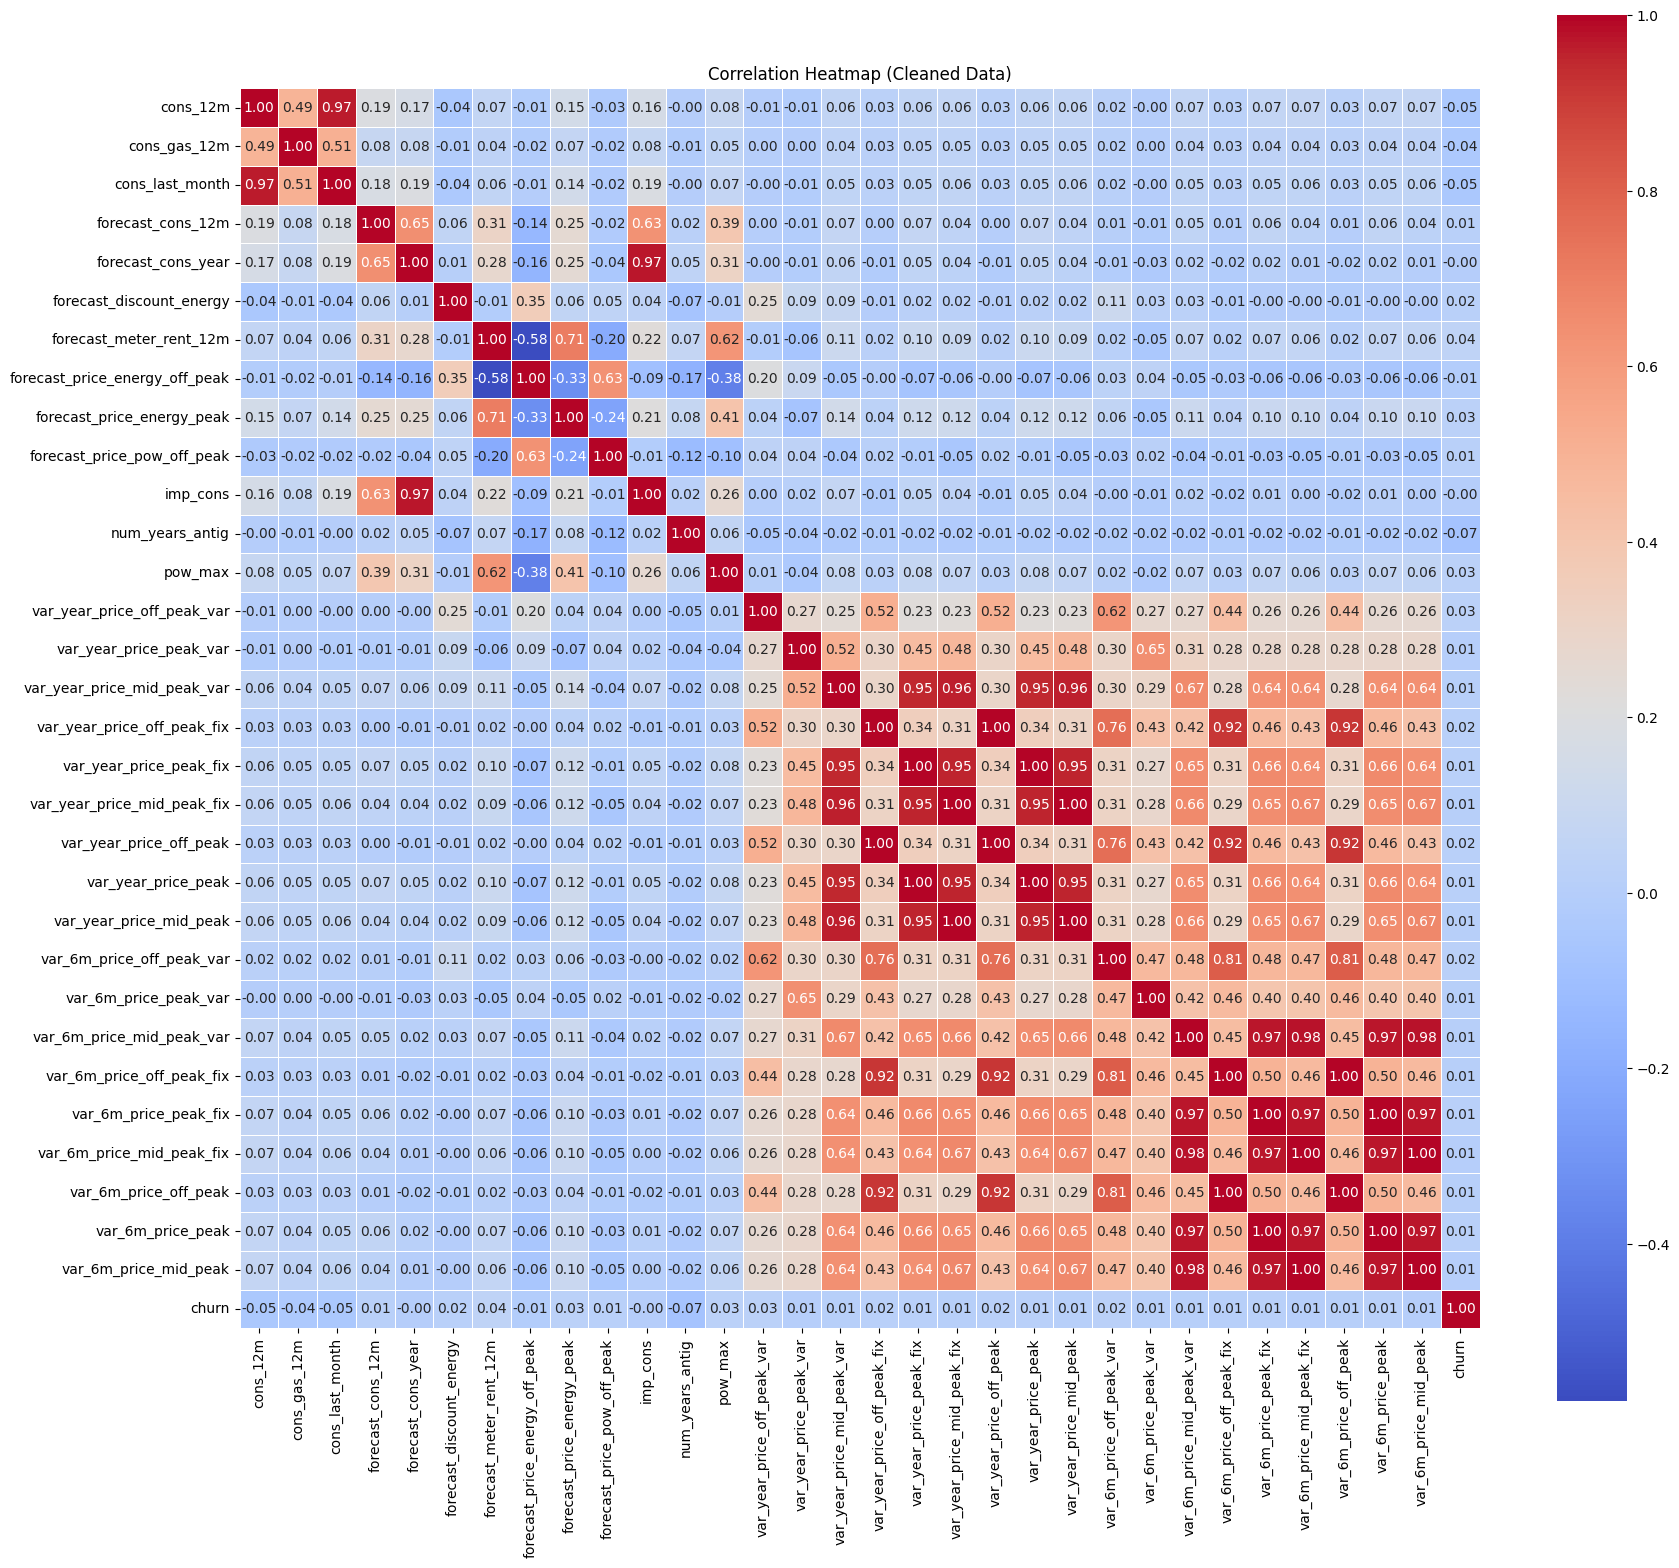

In [41]:
# Only keep numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Heatmap (Cleaned Data)")
plt.show()


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [42]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [43]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


Now it is time to get creative and to conduct some of your own feature engineering! Have fun with it, explore different ideas and try to create as many as yo can!

## Converting Date columns

In [44]:
df['date_activ'] = pd.to_datetime(df['date_activ'])
df['year_activ'] = df['date_activ'].dt.year
df['month_activ'] = df['date_activ'].dt.month

df['date_end'] = pd.to_datetime(df['date_end'])
df['contract_duration_days'] = (df['date_end'] - df['date_activ']).dt.days

df['date_modif_prod'] = pd.to_datetime(df['date_modif_prod'])
df['year_modif_prod'] = df['date_modif_prod'].dt.year
df['month_modif_prod'] = df['date_modif_prod'].dt.month

df['date_renewal'] = pd.to_datetime(df['date_renewal'])
df['year_renewal'] = df['date_renewal'].dt.year
df['month_renewal'] = df['date_renewal'].dt.month



## Creating Ratios

In [46]:
# Forecast accuracy
df['consistency_ratio'] = df['forecast_cons_12m'] / (df['cons_12m'] + 1)

# Recent usage intensity
df['monthly_usage_ratio'] = df['cons_last_month'] / (df['cons_12m'] / 12 + 1)

# Customer tenure if 'num_years_antig' exists
df['tenure_months'] = df['num_years_antig'] * 12


## Merging created features to DF

In [47]:
# Merge price-based change features into main df
df = df.merge(diff, on='id', how='left')

# Fill missing values in new features (just in case)
df[['offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']] = df[
    ['offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']
].fillna(0)

In [50]:
selected_columns = [
    'churn',  # target
    'has_gas',
    'consistency_ratio',
    'monthly_usage_ratio',
    'contract_duration_days',
    'tenure_months',
    'year_activ',
    'month_activ',
    'offpeak_diff_dec_january_energy',
    'offpeak_diff_dec_january_power'
]

model_df = df[selected_columns].copy()